# 1. Setup

In [1]:
import librosa
import librosa.display
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import tensorflow as tf
import torch
import re
import random
import seaborn as sns
import copy

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import json

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Global variables
DATA_PATH = "./data"
LABEL_NAMES = {
      0: "air_conditioner",
      1: "car_horn",
      2: "children_playing",
      3: "dog_bark",
      4: "drilling",
      5: "engine_idling",
      6: "gun_shot",
      7: "jackhammer",
      8: "siren",
      9: "street_music"
}


# 2. Data Exploration

In [3]:
# Read the metadata file
df_meta = pd.read_csv(DATA_PATH + "/UrbanSound8k.csv")

In [4]:
# Show the metadata file
df_meta.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


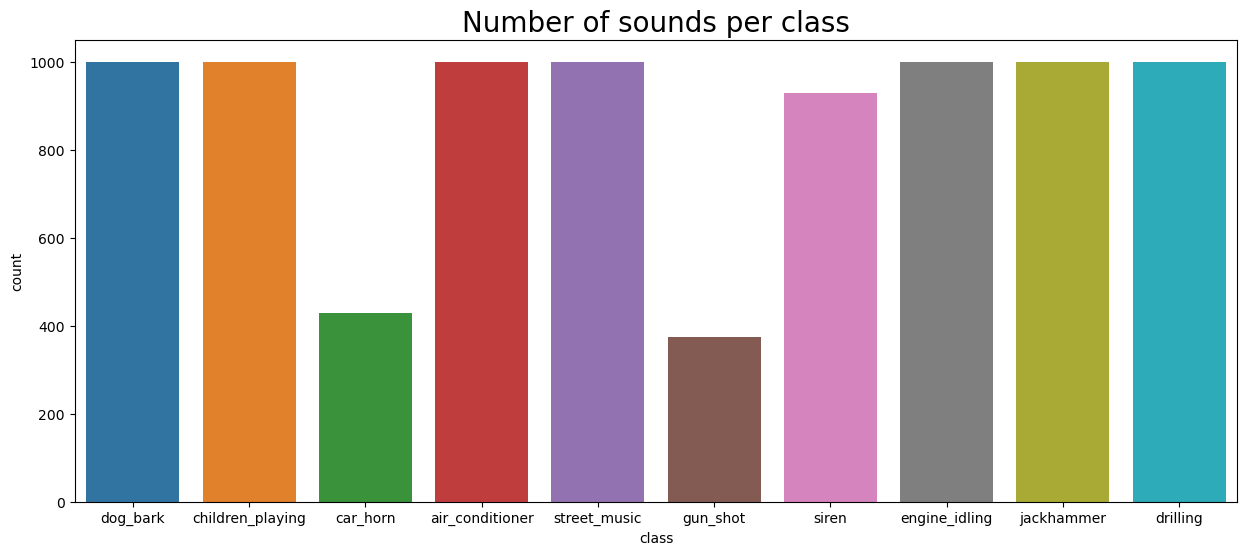

In [5]:
# Number of sounds per class
fig = plt.figure(figsize=(15,6))
plt.title("Number of sounds per class", fontsize= 20)
sns.countplot(x ='class', data = df_meta)
plt.show()

In [6]:
# Get examples of spectograms
def get_spectrograms(hop_length = 512):
    """
    Function that gets example sounds for the 10 classes.
    
        Input: 
            hop_length (int): hop length of the sliding STFT that is being used for the mel spectrogram
        Output:
            Pandas Dataframe with columns "file_name", "fold", "melspectrogram", "label", "label_name", "label_ohe"
    """
    folds = ["fold"+str(i) for i in range(1, 11)]
    df_all = []
    labels = []
    
    for i, fold in enumerate(folds):
        print(f"Loading {fold}")
        fold_path = os.path.join(DATA_PATH, fold)
        fold_content = os.listdir(fold_path)
        for file_name in fold_content:
            label = int(file_name.split("-")[1])
            label_name = LABEL_NAMES[label]
            label_ohe = np.array([1 if i == label else 0 for i in range(10)])
            file_path = os.path.join(fold_path, file_name)
            ts, sr = librosa.load(file_path)
            
            if len(ts) < 88200 or len(ts) > 88200:
                continue

            if label not in labels:
                print("Adding label", label)
                labels.append(label)
                spectrogram = librosa.feature.melspectrogram(y=ts, sr=sr, hop_length = hop_length)
                df_all.append((file_name, i+1, spectrogram, label, label_name, label_ohe))
            
            if len(set(labels)) == 10:
                return pd.DataFrame(df_all, columns = ["file_name", "fold", "melspectrogram", "label", "label_name", "label_ohe"])

    df_all = pd.DataFrame(df_all, columns = ["file_name", "fold", "melspectrogram", "label", "label_name", "label_ohe"])

    return df_all

In [7]:
class_ex = get_spectrograms(690)

Loading fold1
Adding label 2
Adding label 0
Adding label 7
Adding label 4
Adding label 5
Adding label 3
Adding label 8
Adding label 9
Adding label 1
Loading fold2
Adding label 6


In [8]:
class_ex

,file_name,fold,melspectrogram,label,label_name,label_ohe
0,135776-2-0-49.wav,1,"[[7.225768e-05, 4.3156992e-06, 3.8429826e-06, ...",2,children_playing,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,57320-0-0-24.wav,1,"[[31.654509, 22.892565, 93.085785, 38.56957, 3...",0,air_conditioner,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,180937-7-2-6.wav,1,"[[4.1725006, 4.9940143, 1.20474, 0.6169888, 0....",7,jackhammer,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,17913-4-0-1.wav,1,"[[6.527477, 10.286325, 21.359667, 35.334248, 1...",4,drilling,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,176787-5-0-9.wav,1,"[[0.0029183668, 0.00015562413, 1.7100994e-08, ...",5,engine_idling,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
5,138015-3-0-7.wav,1,"[[2.4149609, 3.2796724, 1.6342893, 3.9351685, ...",3,dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
6,157867-8-0-10.wav,1,"[[0.07242782, 0.0060527264, 0.0009548751, 0.00...",8,siren,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7,137156-9-0-73.wav,1,"[[0.003455373, 0.00017385362, 3.7992217e-05, 3...",9,street_music,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
8,24074-1-0-8.wav,1,"[[0.18025611, 0.58512914, 1.973946, 3.4819267,...",1,car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
9,35800-6-0-0.wav,2,"[[2.9666694e-10, 4.5592732e-10, 8.323178e-08, ...",6,gun_shot,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


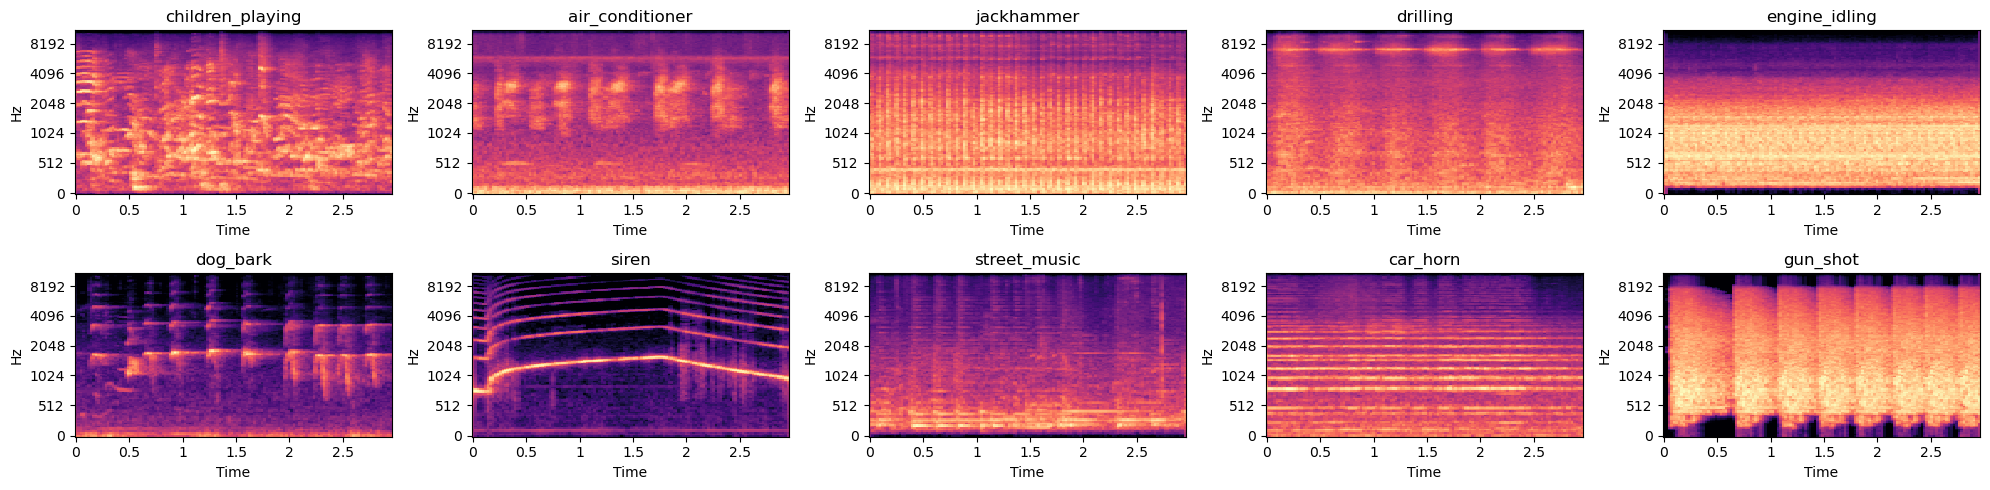

In [9]:
# Plot spectrograms of all 10 classes
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(LABEL_NAMES[class_ex["label"][i]])
    librosa.display.specshow(librosa.power_to_db(class_ex["melspectrogram"][i], ref = np.max), x_axis='time', y_axis='mel') 
plt.tight_layout()

In [10]:
# Class to show mel spectrograms
class Audio:
  def __init__(self, file_path):
    self.file_path = file_path
    self.ts, self.sr = librosa.load(file_path)

  def get_mfccs(self):
    return librosa.feature.mfcc(y = self.ts, sr = self.sr)

  def get_melspectrogram(self, hop_length = 512):
    return librosa.feature.melspectrogram(y=self.ts, sr=self.sr, hop_length = hop_length)

  def show_melspectrogram(self, hop_length = 512):
    img = librosa.display.specshow(librosa.power_to_db(self.get_melspectrogram(hop_length = hop_length), ref = np.max), x_axis='time', y_axis='mel')

In [11]:
dog = Audio(f"{DATA_PATH}/fold1/101415-3-0-2.wav")
children = Audio(f"{DATA_PATH}/fold10/101382-2-0-42.wav")
ac = Audio(f"{DATA_PATH}/fold9/101729-0-0-23.wav")

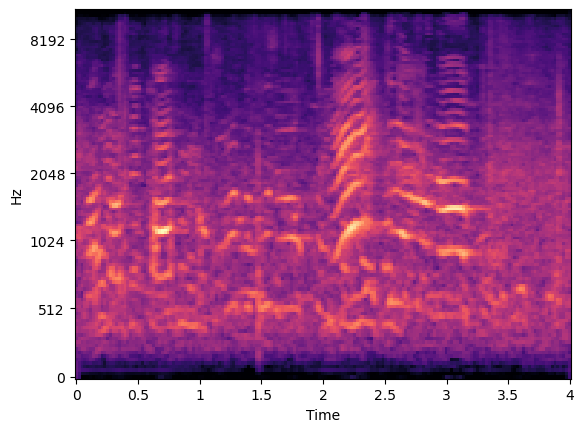

In [12]:
children.show_melspectrogram()

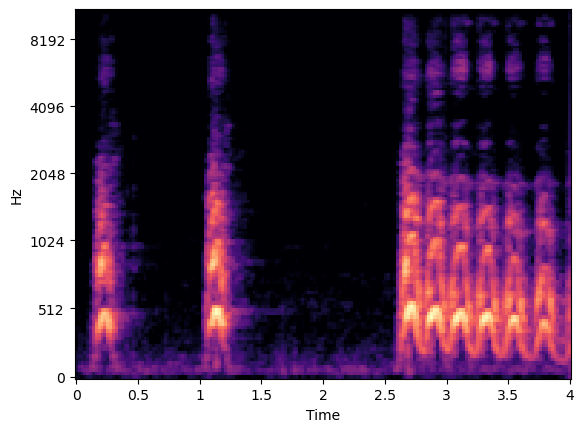

In [13]:
dog.show_melspectrogram()

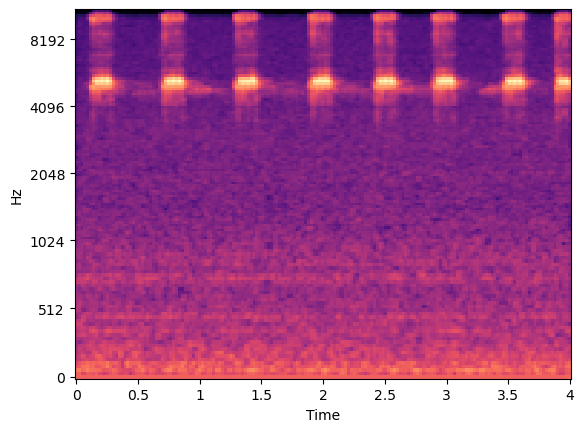

In [14]:
ac.show_melspectrogram()

In [15]:
y, sr = librosa.load(f"{DATA_PATH}/fold10/101382-2-0-42.wav")
print(y.shape)
print(librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 690).shape)
print(librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 512).shape)
print("The shape of the melspectrogram is determined by the hop_length.")

(88200,)
(128, 128)
(128, 173)
The shape of the melspectrogram is determined by the hop_length.



While creating the training dataset, we stumbled on a few issues.
1. 4 audio clips are very short (< n_fft = 2048). This means that the mel-spectrogram will have less fft-bins.
2. The spectograms are sometimes of different shapes. While the number of frequency bins is set to 128, the time-axis is of different lengths. The shape that is the most common is (128, 128) when using a hop length of 690, which is perfect for a audio file of exactly 4 seconds at a sample rate of 22050 Hz.

Our theory is that this indicates that there are significant differences in the length of the sounds. If a song is shorter, the window can make less steps and hence the spectogram is shorter (on the time-axis). This has been confirmed by looking at the spectogram shape and the length of the sound.

Since we want our images to be of the same shape, we could add zero's to all sounds that have a length that is smaller than 88200. That way we keep the frequency patterns (even if a large portion of the spectrogram is black). This will still help us in identifying patterns that correspond to certain labels.

We will do the following preprocessing steps:
1. Add zeros to all songs that are shorter than 4s to obtain a length of 88200.
2. Use a hop-length of 690 to obtain a square picture of shape (128,128).



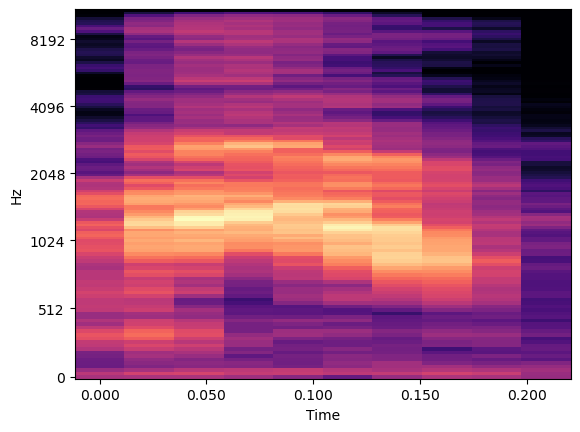

In [16]:
a = Audio(f"{DATA_PATH}/fold1/166268-3-2-0.wav")
a.show_melspectrogram() # This sound is very short, hence its mel-spectrogram is quite small.

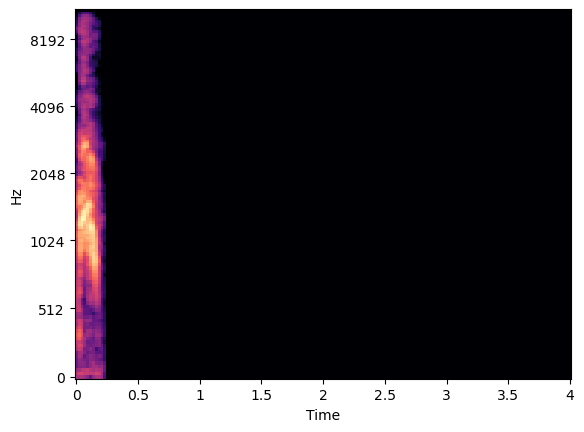

In [17]:
# Solution: add zeros to the ts vector to obtain a length of 88200.
file_path = os.path.join(f"{DATA_PATH}/fold1", "166268-3-2-0.wav")
ts, sr = librosa.load(file_path)
ts = np.append(ts, [0]*(88200-len(ts))) 
spectrogram = librosa.feature.melspectrogram(y=ts, sr=sr)
img = librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=ts, sr=sr), ref = np.max), x_axis='time', y_axis='mel')

# 3. Pre-processing

## 3.1 Helper functions

In [18]:
def create_sample_file(size_per_fold):
    """
        Function that creates a csv-file with the file names of a sample of sounds
        
        Input:
            size_per_fold (int): Number of samples per fold
        Output:
            None
    """
    folds = ["fold"+str(i) for i in range(1, 11)]
    file_names_fold = []
    for i, fold in enumerate(folds):
        fold_path = os.path.join(DATA_PATH, fold)
        fold_content = random.sample(os.listdir(fold_path), size_per_fold)
        for file_name in fold_content:
            file_names_fold.append([i+1, file_name])
    res = pd.DataFrame(file_names_fold, columns = ["fold", "file_name"])
    print(f"Create file files{size_per_fold}.csv")
    res.to_csv(f"files{size_per_fold}.csv", index = False)


def get_train(hop_length = 512, small_sample = True, sample_size = 600):
    """
        Function that creates a dataset with general information of the sound as well as its mel spectrogram.
        Input: 
            hop_length (int): hop length of the sliding STFT that is being used for the mel spectrogram
            small_sample (bool): should the dataset be a sample of the full dataset?
            sample_size (int): size of the sample of each fold
        Output:
            Pandas Dataframe with columns "file_name", "fold", "melspectrogram", "label", "label_name", "label_ohe"
    """
    
    folds = ["fold"+str(i) for i in range(1, 11)]
    df_all = []
    
    # Read file names in sample
    csv_file = f"files{sample_size}.csv"
    if csv_file not in os.listdir():
        print("Create sample file")
        create_sample_file(sample_size)
    files_sample = pd.read_csv(csv_file)
    
    # Iterate through the folds
    for i, fold in enumerate(folds):
        print(f"Loading {fold}")
        fold_path = os.path.join(DATA_PATH, fold)
        fold_content = files_sample[files_sample["fold"] == i+1]["file_name"] if small_sample else os.listdir(fold_path)
        for file_name in fold_content:
            label = int(file_name.split("-")[1])
            label_name = LABEL_NAMES[label]
            label_ohe = np.array([1 if i == label else 0 for i in range(10)])
            file_path = os.path.join(fold_path, file_name)
            ts, sr = librosa.load(file_path)
            if len(ts) < 88200:
                ts = np.append(ts, [0]*(88200-len(ts)))
            elif len(ts) > 88200:
                print(file_name)
                ts = ts[:88200]
            spectrogram = librosa.feature.melspectrogram(y=ts, sr=sr, hop_length = hop_length).flatten()
            df_all.append((file_name, i+1, spectrogram, label, label_name, label_ohe))

    df_all = pd.DataFrame(df_all, columns = ["file_name", "fold", "melspectrogram", "label", "label_name", "label_ohe"])

    return df_all

In [19]:
# Get training set
df_train = get_train(690, True, 500)

Loading fold1
Loading fold2
Loading fold3
Loading fold4
Loading fold5
19007-4-0-0.wav
Loading fold6
Loading fold7
Loading fold8
36429-2-0-15.wav
36429-2-0-7.wav
36429-2-0-14.wav
Loading fold9
Loading fold10


# 3. Cross validation

In [33]:
def series_to_numpy(series):
    """
        Converts a pandas series of lists into a nested list
        
        Input: 
            Pandas series of lists
        Output:
            List of lists
    """
    res = []
    for el in series:
        res.append([x for x in el])
    res_arr = np.array(res)
    return res_arr


def cv_fit(df, func_model, n_epochs, folder):
    """
        This is the main function for fitting the model. The function performs
        cross-validation and fits the model that was passed as an argument. Then,
        it saves the model specification as well as the results in a json file in
        a folder.
        
        Input:
            df (pandas.DataFrame): dataframe with mel spectograms of the sounds
            func_model (function): function that gets the model we want to train. Usually "get_modelXXX"
            n_epochs (int): number of epochs to train model
            folder: destination folder of json file with results
        Output:
            Tuple of:
                hist_list (list): list of history of each fold
                Tuple of:
                    y_pred10: predicted classes for the 10th fold
                    y_val: true classes of the 10th fold
    """
    hist_list = []
    num_folds = 10
    num_samples_per_fold = [fold_size for fold_size in df.groupby("fold").size()]

    # Cross validation -> iterate over folds
    for val_fold in range(1,num_folds+1):
        print("Validation fold:", val_fold)
        
        # Create training and validation data
        df_train = df[df["fold"] != val_fold]
        df_val = df[df["fold"] == val_fold]
        x_train = series_to_numpy(df_train['melspectrogram']).reshape((-1, 128, 128, 1))
        y_train = series_to_numpy(df_train['label_ohe'])
        x_val = series_to_numpy(df_val['melspectrogram']).reshape((-1, 128, 128, 1))
        y_val = series_to_numpy(df_val['label_ohe'])
        
        # Check that no files are in both the training and validation
        if len(set(df_train["file_name"]).intersection(set(df_val["file_name"]))) > 0:
            raise Exception("There is some data that is present both in the train AND test set.")
        
        # Check that the length of x_train + length of x_val is equal to the whole dataset (that we don't forget sounds)
        if len(x_train)+len(x_val) != df.shape[0]:
            raise Exception(f"Not the right shapes! x_train: {len(x_train)}, x_val: {len(x_val)}, df: {df.shape[0]}")
        
        # Fetch model
        model_fold = func_model()
        
        # Print the model summary
        if val_fold == 1:
            print(model_fold.summary())

        # Define callback, which stops training if the loss does not improve for 3 epochs
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
        
        # Fit model
        history = model_fold.fit(
            x_train,
            y_train,
            epochs = n_epochs,
            validation_data=(x_val, y_val),
            callbacks = [callback]
        )
        hist_list.append(history)
    
    # Predict class of 10th fold
    y_pred10 = model_fold.predict(x_train)

    # Compute validation and training accuracy
    best_val_acc = [max(hist_list[i].history["val_accuracy"]) for i in range(num_folds)]
    mean_val_acc = np.average(np.array(best_val_acc), weights = num_samples_per_fold)
    best_train_acc = [max(hist_list[i].history["accuracy"]) for i in range(num_folds)]
    mean_train_acc = np.average(np.array(best_train_acc), weights = num_samples_per_fold)
    
    # Prepare model and history to be saved as json
    model_json = model_fold.to_json()
    history_json = json.dumps([hist.history for hist in hist_list])
    
    # Prepare the folder, remove unnecessary files and define the name of the file to be saved (modelX.json)
    folder_content = os.listdir(folder)
    if '.DS_Store' in folder_content:
        folder_content.remove('.DS_Store')
    if not folder_content:
        dest_file = os.path.join(folder, "model1.json")
    else:
        model_num = list(map(lambda x: int(x.replace("model", "").replace(".json", "")),folder_content))
        max_model_num = max(model_num)
        dest_file = os.path.join(folder, f"model{max_model_num+1}.json")
    
    # Create a new file with the accuracies, history and model architecture
    with open(dest_file, "w") as f:
        f.write(json.dumps({"Number of samples": df.shape[0],
                            "Number of epochs": n_epochs,
                           "mean_best_val_acc": mean_val_acc,
                           "mean_best_train_acc": mean_train_acc}))
        f.write("\n")
        f.write(model_json)
        f.write("\n")
        f.write(history_json)
        
    return hist_list, (y_pred10, y_val)

## 1st Cross-validation step: GENERAL ARCHETYPE

In [21]:
# Variables
NUM_CLASSES = 10
HEIGHT, WIDTH = 128, 128

# 1. Model: Very wide model (2048 filters) but not deep
def get_wide(): 
    model = Sequential([
        layers.Conv2D(512, (3, 3), padding='same', activation='relu', input_shape = (HEIGHT, WIDTH, 1)),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.GlobalAveragePooling2D(),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 2. Model: Semi-deep model with two convolutional layers
def get_mix():
    model = Sequential([
    layers.Conv2D(64, (3,3),activation = 'relu', padding='same', input_shape = (HEIGHT, WIDTH, 1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3),activation = 'relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(num_classes, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3. Model: Deep model with three convolutional layers
def get_deep():
    model = Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (HEIGHT, WIDTH, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 2nd Cross-validation step: MODEL ARCHITECTURE
Here we try to determine the optimal model architecture of the deep model archetype defined above.

In [22]:

def get_model(first_layer, last_layer, batch_norm, dropout):
    """
        Function that extends the deep model of before based on a few options.
        
        Input:
            first_layer (bool): Should the model contain an additional first layer of 16 kernels?
            last_layer (bool): Should the model contain an additional last layer of 256 kernels?
            batch_norm (bool): Should we perform batch normalization after each convolutinal layer?
            dropout (float): Size of dropout (between 0 and 1)
        Output:
            model (tensorflow.keras.models.Sequential)
    """
    model = Sequential()
    if first_layer:
        model.add(layers.Conv2D(16 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(dropout))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(32 , (3,3),activation = 'relu',padding='same'))
    else:
        model.add(layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(dropout))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64 , (3,3),activation = 'relu',padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(dropout))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128 , (3,3),activation = 'relu',padding='same'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(dropout))
    if batch_norm:
        model.add(layers.BatchNormalization())
    if last_layer:
        model.add(layers.Conv2D(256 , (3,3),activation = 'relu',padding='same'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(dropout))
        if batch_norm:
            model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64 , activation = 'relu'))
    model.add(layers.Dense(10, activation = 'sigmoid'))
    
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Cross-validation among model architectures

# Model3.json
def get_model1_0_0_0():
    return get_model(first_layer = True, last_layer = False, batch_norm = False, dropout = 0.3)

# Model4.json
def get_model0_1_0_0():
    return get_model(first_layer = False, last_layer = True, batch_norm = False, dropout = 0.3)

# Model5.json
def get_model0_0_1_0():
    return get_model(first_layer = False, last_layer = False, batch_norm = True, dropout = 0.3)

# Model6.json
def get_model0_0_0_1():
    return get_model(first_layer = False, last_layer = False, batch_norm = False, dropout = 0.5)

# Model7.json
def get_model0_0_0_2():
    return get_model(first_layer = False, last_layer = False, batch_norm = False, dropout = 0.2)

# Model8.json
def get_model0_0_0_3():
    return get_model(first_layer = False, last_layer = False, batch_norm = False, dropout = 0.4)

# Model9.json
def get_model1_1_0_0():
    return get_model(first_layer = True, last_layer = True, batch_norm = False, dropout = 0.3)

# Model10.json
def get_model1_1_0_1():
    return get_model(first_layer = True, last_layer = True, batch_norm = False, dropout = 0.5)

# Model11.json
def get_model0_1_0_3():
    return get_model(first_layer = False, last_layer = True, batch_norm = False, dropout = 0.4)

# Model12.json
def get_flatten():
    model = Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(32, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model13.json
def get_flatten_large():
    model = Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Model 18 
def get_flatten_large_huge():
    model = Sequential([
    layers.Conv2D(16 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



## 3rd Cross-validation step: HYPERPARAMETER TUNING
Here we try to determine the optimal model architecture of the deep model archetype defined above.

In [23]:
######### THIRD CV-STEP #############

# Model14.json
def get_flatten_large_highdrop():
    model = Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(64, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(128, (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model15.json
def get_flatten_large_regl2():
    model = Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1), kernel_regularizer=tf.keras.regularizers.L2(0.1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Model16.json
def get_flatten_large_regl2_2():
    model = Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu',padding='same', input_shape = (128, 128, 1), kernel_regularizer=tf.keras.regularizers.L2(0.01)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Model17.json
def get_flatten_large_stride2():
    model = Sequential([
    layers.Conv2D(32 , (3,3), strides = (1,1), activation = 'relu',padding='same', input_shape = (128, 128, 1)),  
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), strides = (2,2), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), strides = (2,2), activation='relu',padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64 , activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [34]:
# Calling the cross validation function of the best performing model
res = cv_fit(df_train, get_flatten_large_stride2, 13, "./cnn_results/cv_v2")

Validation fold: 1
Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dr

2023-01-13 19:47:18.149537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-13 19:47:18.150151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/13


2023-01-13 19:47:18.474058: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/141 [..............................] - ETA: 52s - loss: 5.8953 - accuracy: 0.0938

2023-01-13 19:47:18.682667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 26ms/step - loss: 2.5629 - accuracy: 0.2711 - val_loss: 2.0412 - val_accuracy: 0.2840
Epoch 2/13


2023-01-13 19:47:22.303486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 3s 24ms/step - loss: 1.8823 - accuracy: 0.3651 - val_loss: 1.8174 - val_accuracy: 0.3480
Epoch 3/13
141/141 [==============================] - 3s 25ms/step - loss: 1.6487 - accuracy: 0.4329 - val_loss: 1.6974 - val_accuracy: 0.4340
Epoch 4/13
141/141 [==============================] - 3s 24ms/step - loss: 1.5355 - accuracy: 0.4702 - val_loss: 1.6394 - val_accuracy: 0.4140
Epoch 5/13
141/141 [==============================] - 3s 24ms/step - loss: 1.4240 - accuracy: 0.5144 - val_loss: 1.6424 - val_accuracy: 0.3780
Epoch 6/13
141/141 [==============================] - 3s 24ms/step - loss: 1.3024 - accuracy: 0.5496 - val_loss: 1.4874 - val_accuracy: 0.4780
Epoch 7/13
141/141 [==============================] - 3s 24ms/step - loss: 1.2839 - accuracy: 0.5544 - val_loss: 1.5213 - val_accuracy: 0.4420
Epoch 8/13
141/141 [==============================] - 3s 23ms/step - loss: 1.1923 - accuracy: 0.5844 - val_loss: 1.4934 - val_accuracy: 0.4580
Epoch 9/13

2023-01-13 19:48:13.850906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 25ms/step - loss: 2.7947 - accuracy: 0.2473 - val_loss: 2.0561 - val_accuracy: 0.3060
Epoch 2/13


2023-01-13 19:48:17.345042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 3s 23ms/step - loss: 1.9005 - accuracy: 0.3380 - val_loss: 1.8408 - val_accuracy: 0.4460
Epoch 3/13
141/141 [==============================] - 3s 23ms/step - loss: 1.7189 - accuracy: 0.3987 - val_loss: 1.7382 - val_accuracy: 0.3420
Epoch 4/13
141/141 [==============================] - 3s 24ms/step - loss: 1.5831 - accuracy: 0.4378 - val_loss: 1.6390 - val_accuracy: 0.4460
Epoch 5/13
141/141 [==============================] - 3s 23ms/step - loss: 1.4644 - accuracy: 0.4964 - val_loss: 1.5781 - val_accuracy: 0.3880
Epoch 6/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3856 - accuracy: 0.5162 - val_loss: 1.6467 - val_accuracy: 0.4280
Epoch 7/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2946 - accuracy: 0.5478 - val_loss: 1.5816 - val_accuracy: 0.3860
Epoch 8/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2401 - accuracy: 0.5604 - val_loss: 1.5798 - val_accuracy: 0.4000
Epoch 9/13

2023-01-13 19:49:08.148889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 25ms/step - loss: 2.6547 - accuracy: 0.2629 - val_loss: 2.0460 - val_accuracy: 0.2860
Epoch 2/13


2023-01-13 19:49:11.655030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 3s 23ms/step - loss: 1.9582 - accuracy: 0.3420 - val_loss: 1.7757 - val_accuracy: 0.4040
Epoch 3/13
141/141 [==============================] - 3s 24ms/step - loss: 1.7277 - accuracy: 0.4049 - val_loss: 1.6181 - val_accuracy: 0.4200
Epoch 4/13
141/141 [==============================] - 3s 23ms/step - loss: 1.6047 - accuracy: 0.4473 - val_loss: 1.6010 - val_accuracy: 0.4160
Epoch 5/13
141/141 [==============================] - 3s 23ms/step - loss: 1.4631 - accuracy: 0.4867 - val_loss: 1.5428 - val_accuracy: 0.4800
Epoch 6/13
141/141 [==============================] - 3s 24ms/step - loss: 1.3674 - accuracy: 0.5229 - val_loss: 1.6067 - val_accuracy: 0.4660
Epoch 7/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2711 - accuracy: 0.5604 - val_loss: 1.6311 - val_accuracy: 0.4700
Epoch 8/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2065 - accuracy: 0.5820 - val_loss: 1.5677 - val_accuracy: 0.5320
Epoch 9/13

2023-01-13 19:50:03.470691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 26ms/step - loss: 2.7963 - accuracy: 0.2393 - val_loss: 2.1625 - val_accuracy: 0.2280
Epoch 2/13


2023-01-13 19:50:07.066372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 3s 24ms/step - loss: 1.9164 - accuracy: 0.3400 - val_loss: 2.0249 - val_accuracy: 0.3460
Epoch 3/13
141/141 [==============================] - 3s 24ms/step - loss: 1.7365 - accuracy: 0.4162 - val_loss: 1.9442 - val_accuracy: 0.4000
Epoch 4/13
141/141 [==============================] - 3s 24ms/step - loss: 1.5952 - accuracy: 0.4462 - val_loss: 1.7881 - val_accuracy: 0.3580
Epoch 5/13
141/141 [==============================] - 3s 24ms/step - loss: 1.4480 - accuracy: 0.4980 - val_loss: 1.7628 - val_accuracy: 0.3780
Epoch 6/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3965 - accuracy: 0.5138 - val_loss: 1.7793 - val_accuracy: 0.3780
Epoch 7/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2626 - accuracy: 0.5547 - val_loss: 1.8558 - val_accuracy: 0.3880
Epoch 8/13
141/141 [==============================] - 3s 24ms/step - loss: 1.2655 - accuracy: 0.5651 - val_loss: 1.6554 - val_accuracy: 0.4380
Epoch 9/13

2023-01-13 19:50:57.702376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 25ms/step - loss: 2.5578 - accuracy: 0.2460 - val_loss: 2.0782 - val_accuracy: 0.2640
Epoch 2/13


2023-01-13 19:51:01.220345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 3s 24ms/step - loss: 1.8969 - accuracy: 0.3553 - val_loss: 2.0568 - val_accuracy: 0.3320
Epoch 3/13
141/141 [==============================] - 3s 23ms/step - loss: 1.7037 - accuracy: 0.4182 - val_loss: 1.9011 - val_accuracy: 0.2680
Epoch 4/13
141/141 [==============================] - 3s 24ms/step - loss: 1.5683 - accuracy: 0.4478 - val_loss: 1.9131 - val_accuracy: 0.3720
Epoch 5/13
141/141 [==============================] - 3s 23ms/step - loss: 1.4646 - accuracy: 0.4864 - val_loss: 1.8141 - val_accuracy: 0.3360
Epoch 6/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3933 - accuracy: 0.5187 - val_loss: 1.6299 - val_accuracy: 0.3660
Epoch 7/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3074 - accuracy: 0.5476 - val_loss: 1.6360 - val_accuracy: 0.4320
Epoch 8/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2565 - accuracy: 0.5600 - val_loss: 1.5535 - val_accuracy: 0.5080
Epoch 9/13

2023-01-13 19:51:53.095904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - ETA: 0s - loss: 2.8455 - accuracy: 0.2598

2023-01-13 19:51:56.660110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 5s 25ms/step - loss: 2.8455 - accuracy: 0.2598 - val_loss: 2.0827 - val_accuracy: 0.2180
Epoch 2/13
141/141 [==============================] - 3s 24ms/step - loss: 1.9498 - accuracy: 0.3327 - val_loss: 1.9787 - val_accuracy: 0.3680
Epoch 3/13
141/141 [==============================] - 3s 24ms/step - loss: 1.7722 - accuracy: 0.3918 - val_loss: 1.8148 - val_accuracy: 0.3080
Epoch 4/13
141/141 [==============================] - 3s 23ms/step - loss: 1.5990 - accuracy: 0.4567 - val_loss: 1.8363 - val_accuracy: 0.3760
Epoch 5/13
141/141 [==============================] - 3s 24ms/step - loss: 1.4891 - accuracy: 0.4836 - val_loss: 1.8531 - val_accuracy: 0.3660
Epoch 6/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3791 - accuracy: 0.5233 - val_loss: 1.6553 - val_accuracy: 0.4660
Epoch 7/13
141/141 [==============================] - 3s 24ms/step - loss: 1.2886 - accuracy: 0.5507 - val_loss: 1.7432 - val_accuracy: 0.3680
Epoch 8/13

2023-01-13 19:52:47.423750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 25ms/step - loss: 2.6600 - accuracy: 0.2569 - val_loss: 2.0796 - val_accuracy: 0.2780
Epoch 2/13


2023-01-13 19:52:50.938560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 3s 23ms/step - loss: 1.9455 - accuracy: 0.3333 - val_loss: 1.8461 - val_accuracy: 0.3540
Epoch 3/13
141/141 [==============================] - 3s 24ms/step - loss: 1.7134 - accuracy: 0.4120 - val_loss: 1.7121 - val_accuracy: 0.4180
Epoch 4/13
141/141 [==============================] - 3s 24ms/step - loss: 1.5768 - accuracy: 0.4596 - val_loss: 1.6120 - val_accuracy: 0.4180
Epoch 5/13
141/141 [==============================] - 3s 23ms/step - loss: 1.4865 - accuracy: 0.4904 - val_loss: 1.4868 - val_accuracy: 0.4960
Epoch 6/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3906 - accuracy: 0.5187 - val_loss: 1.4648 - val_accuracy: 0.4820
Epoch 7/13
141/141 [==============================] - 3s 24ms/step - loss: 1.3124 - accuracy: 0.5440 - val_loss: 1.4152 - val_accuracy: 0.4760
Epoch 8/13
141/141 [==============================] - 3s 23ms/step - loss: 1.2699 - accuracy: 0.5736 - val_loss: 1.4848 - val_accuracy: 0.4440
Epoch 9/13

2023-01-13 19:53:41.198333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - ETA: 0s - loss: 2.6117 - accuracy: 0.2518

2023-01-13 19:53:44.719587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 25ms/step - loss: 2.6117 - accuracy: 0.2518 - val_loss: 2.0994 - val_accuracy: 0.3060
Epoch 2/13
141/141 [==============================] - 3s 24ms/step - loss: 1.9106 - accuracy: 0.3378 - val_loss: 1.8401 - val_accuracy: 0.4180
Epoch 3/13
141/141 [==============================] - 3s 23ms/step - loss: 1.6886 - accuracy: 0.4156 - val_loss: 1.6547 - val_accuracy: 0.4600
Epoch 4/13
141/141 [==============================] - 3s 23ms/step - loss: 1.5378 - accuracy: 0.4622 - val_loss: 1.7163 - val_accuracy: 0.5240
Epoch 5/13
141/141 [==============================] - 3s 24ms/step - loss: 1.4593 - accuracy: 0.4982 - val_loss: 1.7936 - val_accuracy: 0.5280
Epoch 6/13
141/141 [==============================] - 3s 23ms/step - loss: 1.3519 - accuracy: 0.5329 - val_loss: 1.8201 - val_accuracy: 0.5400
Epoch 7/13
141/141 [==============================] - 3s 24ms/step - loss: 1.2743 - accuracy: 0.5524 - val_loss: 1.6976 - val_accuracy: 0.5680
Epoch 8/13

2023-01-13 19:54:34.903240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - ETA: 0s - loss: 2.7274 - accuracy: 0.2620

2023-01-13 19:54:38.453248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 25ms/step - loss: 2.7274 - accuracy: 0.2620 - val_loss: 2.6014 - val_accuracy: 0.2700
Epoch 2/13
141/141 [==============================] - 3s 23ms/step - loss: 1.9155 - accuracy: 0.3393 - val_loss: 2.8332 - val_accuracy: 0.3320
Epoch 3/13
141/141 [==============================] - 3s 23ms/step - loss: 1.7374 - accuracy: 0.3989 - val_loss: 3.4319 - val_accuracy: 0.3380
Epoch 4/13
141/141 [==============================] - 3s 24ms/step - loss: 1.5575 - accuracy: 0.4558 - val_loss: 3.0132 - val_accuracy: 0.4520
Epoch 5/13
141/141 [==============================] - 3s 23ms/step - loss: 1.4646 - accuracy: 0.4898 - val_loss: 2.7073 - val_accuracy: 0.4280
Epoch 6/13
141/141 [==============================] - 3s 24ms/step - loss: 1.3501 - accuracy: 0.5236 - val_loss: 3.1373 - val_accuracy: 0.5000
Epoch 7/13
141/141 [==============================] - 3s 24ms/step - loss: 1.2741 - accuracy: 0.5647 - val_loss: 3.0816 - val_accuracy: 0.4860
Epoch 8/13

2023-01-13 19:55:29.050940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - ETA: 0s - loss: 2.6038 - accuracy: 0.2596

2023-01-13 19:55:32.596319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 4s 26ms/step - loss: 2.6038 - accuracy: 0.2596 - val_loss: 1.9930 - val_accuracy: 0.3540
Epoch 2/13
141/141 [==============================] - 3s 23ms/step - loss: 1.9242 - accuracy: 0.3464 - val_loss: 1.7479 - val_accuracy: 0.3280
Epoch 3/13
141/141 [==============================] - 3s 24ms/step - loss: 1.6732 - accuracy: 0.4204 - val_loss: 1.6559 - val_accuracy: 0.4260
Epoch 4/13
141/141 [==============================] - 3s 23ms/step - loss: 1.5725 - accuracy: 0.4560 - val_loss: 1.7300 - val_accuracy: 0.4020
Epoch 5/13
141/141 [==============================] - 3s 23ms/step - loss: 1.4471 - accuracy: 0.4927 - val_loss: 1.7134 - val_accuracy: 0.4560
Epoch 6/13
141/141 [==============================] - 3s 24ms/step - loss: 1.3721 - accuracy: 0.5220 - val_loss: 1.6629 - val_accuracy: 0.4740
Epoch 7/13
141/141 [==============================] - 3s 24ms/step - loss: 1.2696 - accuracy: 0.5576 - val_loss: 1.7670 - val_accuracy: 0.4420
Epoch 8/13

2023-01-13 19:56:12.892956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


141/141 [==============================] - 1s 5ms/step
